# Community Space Distribution and Attendance


## Introduction
In an era of less face-to-face interaction with increasing digital connectivity, the sense of community fostered by public spaces and gatherings gradually fades. Community Centers are one avenue of preservation nonetheless -- being public venues for socialization and recreational activity, their active function within a neighborhood can signify a close-knit community. Here, we seek to analyze the distribution of these centers as a metric of community.

### Dataset Used

- [City of Pittsburgh Facilities (WRDOC)](https://data.wprdc.org/dataset/city-of-pittsburgh-facilities/resource/fbb50b02-2879-47cd-abea-ae697ec05170)

Lists a number of public facilities around Pittsburgh.

#### Density of Community Spaces
We will begin by importing pandas and geopandas to analyze the datasets.

In [72]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import fpsnippets
from shapely.geometry import Point
%matplotlib inline


With our libraries available for use, we will import our City of Pittsburgh Facilities dataset and name it "facilities". 

In [15]:
facilities = pd.read_csv('Datasets/city-facilities.csv')
facilities.head(3)

,_id,id,parcel_id,inactive,name,rentable,type,primary_user,address_number,street,...,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1,650726265,120-J-300,f,57th Street Park Building,f,Storage,Department of Public Works,NaN,57TH ST,...,Upper Lawrenceville,7,10.0,42003101100,2.0,10.0,2.0,3-5,40.485666,-79.946450
1,2,783044037,2-H-284,f,Albert Turk Graham Park Shelter,f,Shelter,Department of Public Works,39.0,VINE ST,...,Crawford-Roberts,6,3.0,42003030500,3.0,3.0,2.0,2-1,40.440458,-79.984104
2,3,1997158435,23-R-157,f,Allegheny Northside Senior Center and Hazlett ...,t,Senior,CitiParks,5.0,ALLEGHENY SQ E,...,Allegheny Center,1,22.0,42003562700,1.0,22.0,1.0,1-6,40.453099,-80.005343


You will note, from a preliminary list of 3 rows, that the data contains a number of columns as well as types of facilities irrelevant to the overarching metric. We would like to sift through the dataset and target recreational spaces instead. To understand what data we work with, we will first extract a list of facilty types to determine how to splice the set.

In [94]:
# List the different possible names for the 'type' column
print(facilities['type'].unique())

['Storage' 'Shelter' 'Senior' 'Pool' 'Utility' 'Activity' 'Restrooms'
 'Service' 'Concession' 'Dugout' 'Pool/Rec' 'Rec Center' 'Office'
 'Pool Closed' 'Firehouse' 'Community' 'Vacant' 'Cabin' 'Medic Station'
 'Training' 'Police' 'Salt Dome' 'Recycling' 'SERVICE' 'STORAGE' 'POLICE'
 'TRAINING' 'OFFICE']



We can now see what types of facilities the dataset has provided us! To determine the density of community spaces, we will extract data entries deemed types 'Pool', 'Pool/Rec', 'Rec Center', 'Dugout', 'Senior', 'Shelter', and 'Community' to their own library. 

To do this, we will create a query mask of our terms and apply them to the entire dataframe.


In [89]:
spaces = ['Pool', 'Pool/Rec', 'Rec Center', 'Community', 'Senior', 'Shelter', 'Dugout']
typemask = facilities['type'].isin(spaces)
filtered = facilities[typemask]
filtered.sample(3)

,_id,id,parcel_id,inactive,name,rentable,type,primary_user,address_number,street,...,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
40,41,73475635,96-G-1,f,Brookline Pool Guard Room,f,Pool,CitiParks,1400.0,OAKRIDGE ST,...,Brookline,4,32.0,42003320600,5.0,32.0,6.0,4-26,40.390749,-80.007548
140,141,1232356456,82-H-1-0-2,f,Highland Park Elm Grove Shelter,t,Shelter,Department of Public Works,6900.0,LAKE DR,...,Highland Park,7,11.0,42003980100,2.0,11.0,5.0,3-9,40.476697,-79.910398
225,226,1443094810,12-G-225,f,Ormsby Pool and Recreation Center,t,Pool/Rec,CitiParks,79.0,S 22ND ST,...,South Side Flats,3,16.0,42003160900,3.0,16.0,3.0,4-24,40.429090,-79.974297


This query mask has allowed us to create a filtered data frame of community spaces. Still, to tidy up the data even further, let's form an entirely new frame with only the data we need -- we will include the name of the community space as well as its type and coordinates.

In [90]:
facil = pd.DataFrame(columns = ['Name', 'Type', 'Latitude', 'Longitude'])
facil['Name'] = filtered['name']
facil['Type'] = filtered['type']
facil['Latitude'] = filtered['latitude']
facil['Longitude'] = filtered['longitude']

print(len(facil))
facil.head(10)


161


,Name,Type,Latitude,Longitude
1,Albert Turk Graham Park Shelter,Shelter,40.440458,-79.984104
2,Allegheny Northside Senior Center and Hazlett ...,Senior,40.453099,-80.005343
3,Ammon Recreation Center,Pool,40.448735,-79.977856
6,Arlington Pool Restrooms,Pool,40.417753,-79.974688
14,Banksville Deck Hockey Benches,Dugout,40.414327,-80.038920
15,Banksville Park Gazebo,Shelter,40.414653,-80.039286
16,Banksville Pool Building and Shelter,Pool,40.414784,-80.040176
17,Beechview Senior and Community Center,Senior,40.410741,-80.024363
18,Bloomfield Deck Hockey Benches,Dugout,40.462618,-79.953666
19,Bloomfield Pool and Recreation Center,Pool/Rec,40.462133,-79.953589


This is a much cleaner representation! We will now seek to determine the distribution of these 161 facilities to see which neighborhoods contain more spaces.

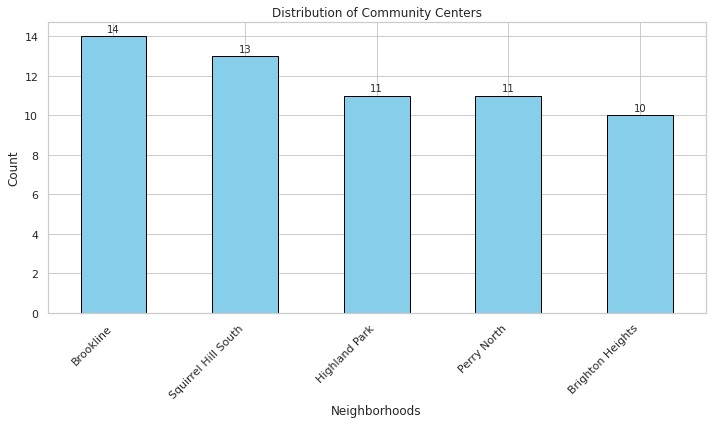

In [91]:
nlist = []
counts = []
for index, row in facil.iterrows():
    lat = row["Latitude"]
    lon = row["Longitude"]
    nlist.append(fpsnippets.geo_to_neighborhood(lat, lon))

distribution = pd.DataFrame(nlist, columns = ["neighborhood"])
neighbors = distribution["neighborhood"].value_counts().head(8)

plt.figure(figsize=(10, 6))
neighbors.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Community Centers')
plt.xlabel('Neighborhoods')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the count values on top of each bar
for i, value in enumerate(neighbors):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


From the data represented, it appears as though Brookline leads in its number of community spaces with 14. 

For this metric:
##### 1) Brookline
##### 2) Squirrel Hill South
##### 3) Highland Park